<h2> Best Source: </h2>
http://ucanalytics.com/blogs/wp-content/uploads/2017/08/ARIMA-TimeSeries-Analysis-of-Tractor-Sales.html
<br>

<h3> Other Sources</h3>
https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
<br>
http://ucanalytics.com/blogs/forecasting-time-series-analysis-manufacturing-case-study-example-part-1/
<br>
http://ucanalytics.com/blogs/time-series-decomposition-manufacturing-case-study-example-part-2/
<br>
http://ucanalytics.com/blogs/arima-models-manufacturing-case-study-example-part-3/
<br>
http://ucanalytics.com/blogs/step-by-step-graphic-guide-to-forecasting-through-arima-modeling-in-r-manufacturing-case-study-example/
<br>

In [2]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

C:\Users\MY PC\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
from io import StringIO
import requests

sales_data = pd.read_csv('Tractor-Sales.csv')
sales_data.head(5)

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [22]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))
#dates[0].month
#dates[0].year

In [23]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

sales_data.head(5)

,Month-Year,Number of Tractor Sold,Month,Year
0,Jan-03,141,Jan,2003
1,Feb-03,157,Feb,2003
2,Mar-03,185,Mar,2003
3,Apr-03,199,Apr,2003
4,May-03,203,May,2003


In [24]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]
sales_data.head(5)

,Month,Year,Tractor-Sales
0,Jan,2003,141
1,Feb,2003,157
2,Mar,2003,185
3,Apr,2003,199
4,May,2003,203


In [25]:
sales_data.set_index(dates, inplace=True)
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [26]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

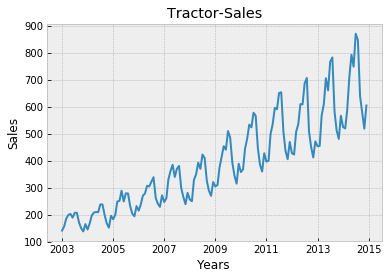

In [27]:
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Sales')
plt.title('Tractor-Sales')
plt.figure(figsize=(10,5))

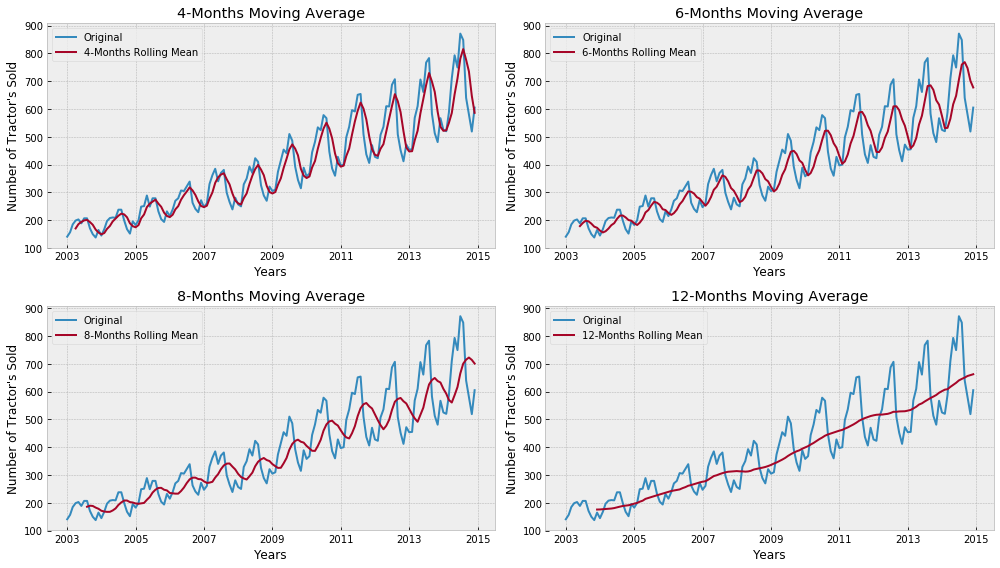

In [28]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

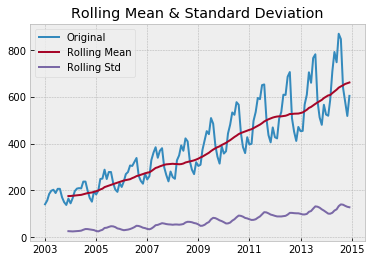

In [29]:
#Determing rolling statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [30]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


<h3> Time Series Decomposition</h3>

1) Sesonality 

In [31]:
monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


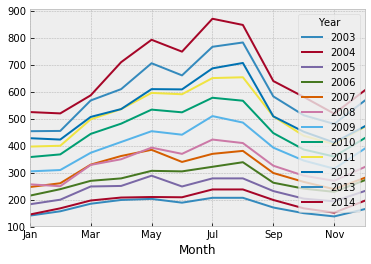

In [32]:
monthly_sales_data.plot()

In [33]:
yearly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


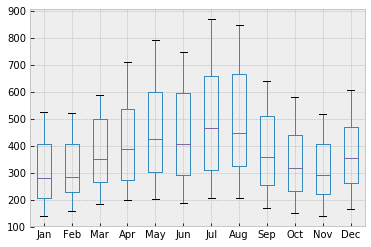

In [34]:
yearly_sales_data.boxplot()

<h4>IMPORTANT INFERENCES</h4>


<p>1) The tractor sales have been increasing without fail every year.</p>
<p>2) July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.</p>
<p>3) We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of  the year. We can see a seasonal effect with a cycle of 12 months.</p>

<h4>To decipher underlying patterns in tractor sales we must DECOMPOSE the series.</h4>

In [35]:

decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')

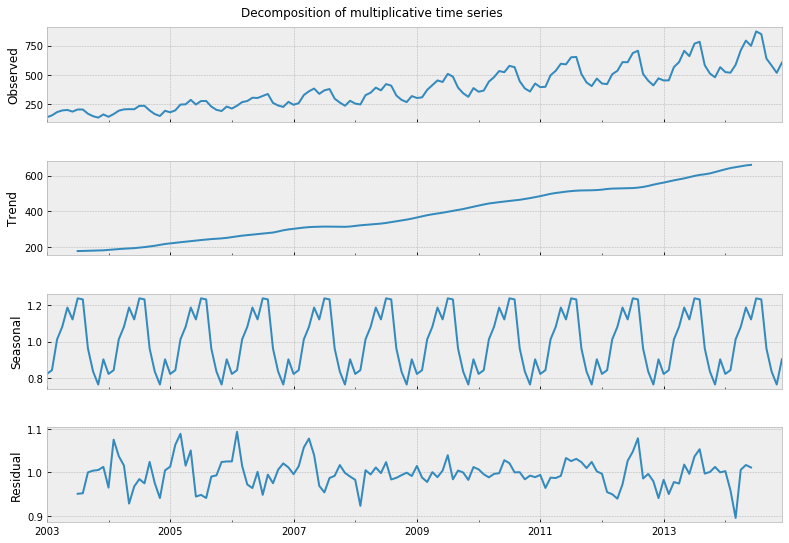

In [36]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

<h3>Step 2:</h3> <b>Difference data to make data stationary on mean (remove trend)</b>

<p>
Clearly the tractor sales has an upward trend for tractors sales and there is also a seasonal component that we have already analyzed.
The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:
1st Differencing (d=1)
Y′t=Yt−Yt−1
</p>

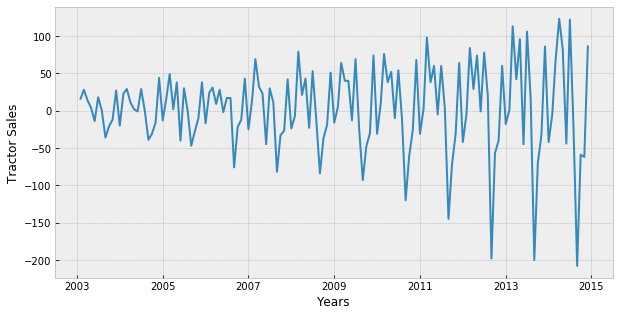

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

<h3>Step 3:</h3> <b>log transform data to make data stationary on variance</b>

<p>
One of the best ways to make a series stationary on variance is through transforming the original series through log transform. We will go back to our original tractor sales series and log transform it to make it stationary on variance. The following equation represents the process of log transformation mathematically:
Log of sales :  Yt$new$=log10(Yt)
<br>
Notice, this series is not stationary on mean since we are using the original data without differencing. But now the series looks stationary on variance.
</p>

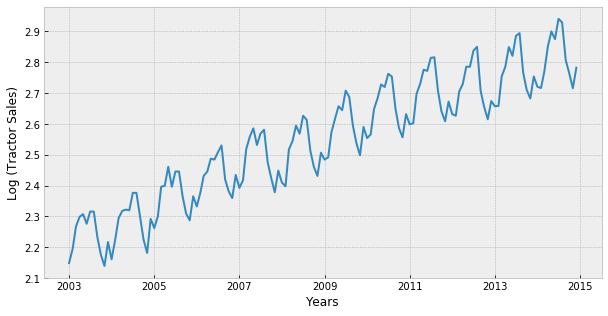

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')

<h3>Step 4:</h3> <p>Difference log transform data to make data stationary on both mean and variance.</p>

<p>
Let us look at the differenced plot for log transformed series to reconfirm if the series is actually stationary on both mean and variance.
1st Differencing (d=1) of Log of sales : <br> Yt$new$=log$10$(Yt)−log$10$(Yt−1)</p>

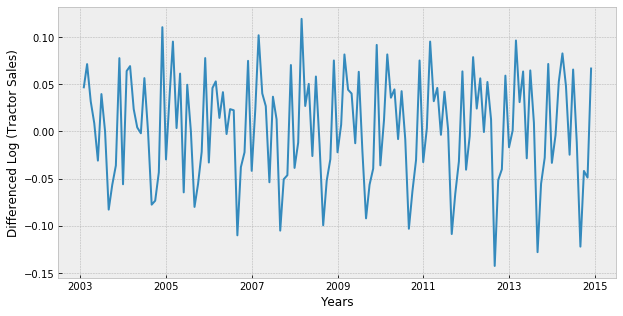

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

<h3>Step 5:</h3> <p>Plot ACF and PACF to identify potential AR and MA model</p>

In [43]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

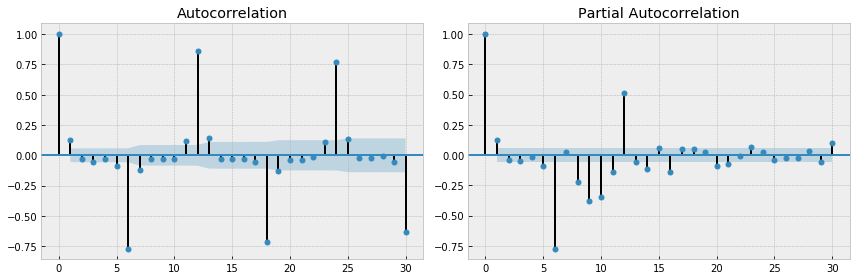

In [44]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()


<h3>Step 6:</h3> <p>Identification of best fit ARIMA model</p>

In [45]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [48]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None 
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-733.7733673716689


<h3>Step 7:</h3> <p>Predict sales on in-sample date using the best fit ARIMA model</p>


In [49]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [50]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [51]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]

# Compute the mean square error
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0011


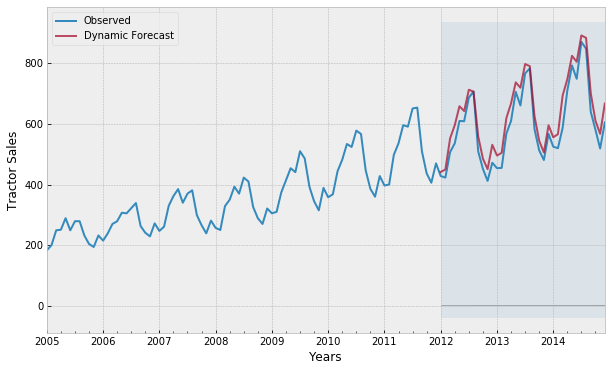

In [52]:
axis = sales_ts['2005':].plot(label='Observed', figsize=(10, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

<h3>Step 8:</h3> <p>Forecast sales using the best fit ARIMA model</p>

In [53]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [54]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.456687,528.240504,609.584249,528.240504,609.584249
2015-01-01,566.229020,520.024180,616.539221,520.024180,616.539221
2015-02-01,668.976317,607.275832,736.945699,607.275832,736.945699
2015-03-01,755.240824,678.501349,840.659643,678.501349,840.659643
2015-04-01,850.266908,756.677085,955.432415,756.677085,955.432415


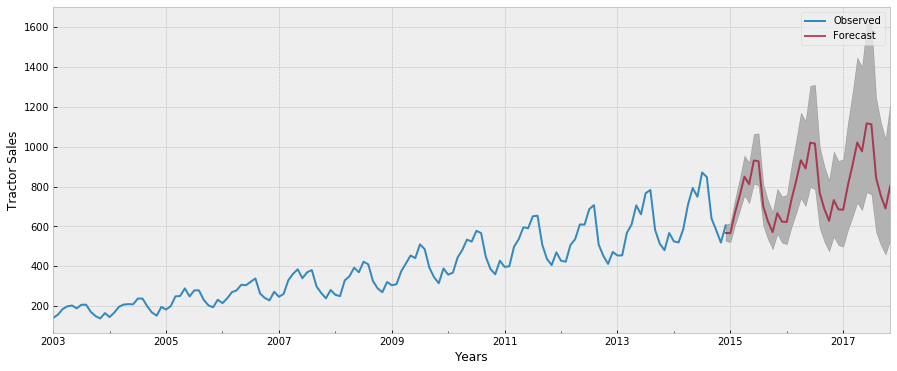

In [55]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

<h3>Step 9:</h3><p> Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction</p>

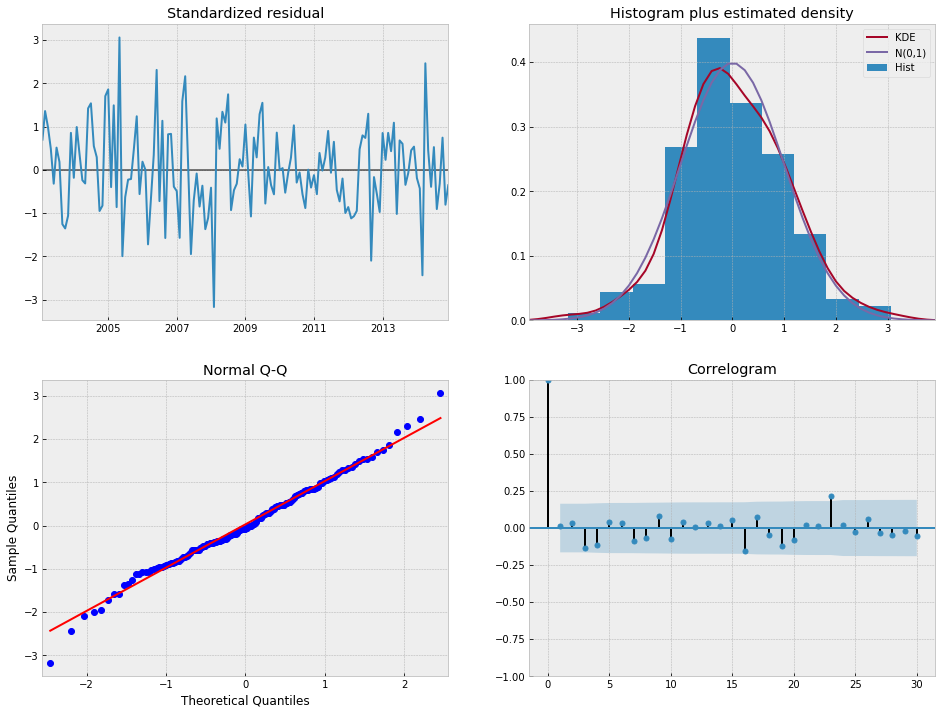

In [56]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

<p>We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.</p>
<br>
In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:<br><br>

1) The KDE plot of the residuals on the top right is almost similar with the normal distribution.<br>

2) The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.<br>

3) The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.<br>
<br>
<br>
<br>
Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It seems that our ARIMA model is working fine.